<a href="https://colab.research.google.com/github/mhfaisaluddin/Churn-Prediction-on-Credit-Card-Data/blob/main/churn_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Overview**:
1. Get and download the data from Kaggle, and quick-learn about the data & the domain. Source:
    - https://www.kaggle.com/datasets/sakshigoyal7/credit-card-customers
2. **Data Collection and Understanding**, import the dataset and preview its information.
3. **EDA**, explore and extract the information. This step contains the statistical summary, uni- and multi-variate analysis, including the 'deep-dive question' and the summary.
4. **Data Preprocessing**, prepare the data before modeling. Split the data into train-test, missing value handling, multicollinearity study, and encoding. Due to the imbalanced data, we include SMOTE to oversample the train data. 
5. **Modeling**, build a predictive model by using supervised learning (distance-based ML: KNN, and tree-based ML: Decision Tree, and Random Forest), and get the best model through evaluating the model performance and hyperparameter tuning.
6. **Model Interpretability**, support the model with explained prediction through permutation feature importance and SHAP.

Expected output: the action insight/business recommendation based on the EDA, and behavior of the churn customers.

# Predicting Churn on Credit Card Customer Data 

**The business problem**

A customer is considered churn when he/she leaves the credit card service or fails to renew the contract. The churn case can be a major business problem when it doesn't get maintained. Besides that, the cost of gaining a new customer is higher than retaining the recent one. In order to prevent churn from customers, we can apply classification modeling to predict the probability of a customer churning. The benefit of churn prediction itself can lead us to optimize marketing expenditure to a targeted marketing campaign.

**Objectives**

Motivated by the problem above, the objectives of this project are:
- Try to detect the potential pattern of customers who choose to churn.
- Build a classification model to predict the probability of a customer churning.
- Provide recommendations to retain existing customers.

# Import Libraries
This project includes some visualization, preprocessing, and machine learning (scikit-learn) library.

In [2]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 5.3 MB/s 


In [3]:
# import library
import pandas as pd
import numpy as np

# visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE

# ML
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier      # distance based ML
from sklearn.tree import DecisionTreeClassifier         # tree based ML
from sklearn.ensemble import RandomForestClassifier 

# hyperparameter tune
from sklearn.model_selection import GridSearchCV

# evaluation metric
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, make_scorer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve

# model interpretability
from sklearn.inspection import permutation_importance
import shap

# visualization set up
sns.set(rc={'figure.figsize':(20,8)})
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")
palette=['#003566', '#ffa200']

# Data Collection

In [4]:
# read the data
df = pd.read_csv('https://raw.githubusercontent.com/mhfaisaluddin/Churn-Prediction-on-Credit-Card-Data/main/BankChurners.csv')

# exclude 2 last columns
data = df[df.columns[:-2]]

data.columns = data.columns.str.lower()
data.head()

,clientnum,attrition_flag,customer_age,gender,dependent_count,education_level,marital_status,income_category,card_category,months_on_book,...,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


# Data Understanding

## General Information

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   clientnum                 10127 non-null  int64  
 1   attrition_flag            10127 non-null  object 
 2   customer_age              10127 non-null  int64  
 3   gender                    10127 non-null  object 
 4   dependent_count           10127 non-null  int64  
 5   education_level           10127 non-null  object 
 6   marital_status            10127 non-null  object 
 7   income_category           10127 non-null  object 
 8   card_category             10127 non-null  object 
 9   months_on_book            10127 non-null  int64  
 10  total_relationship_count  10127 non-null  int64  
 11  months_inactive_12_mon    10127 non-null  int64  
 12  contacts_count_12_mon     10127 non-null  int64  
 13  credit_limit              10127 non-null  float64
 14  total_

- The raw data consist of 10127 rows and 21 columns.
- Some categorical data is still in object data types. All of the numerical data are in the correct type.
- The target is `attrition_flag`, customer separated into Attrited Customer (Churn) and Existing Customer.
- No need to use `clientnum` (client number) in this analysis.

**The columns info**
- `clientnum` : Client number. Unique identifier for the customer holding the account
- `attrition_flag` : Internal event (customer activity) variable - if the account is closed then 1 else 0
- `customer_age` : Demographic variable - Customer's Age in Years
- `gender` : Demographic variable - M=Male, F=Female
- `dependent_count` : Demographic variable - Number of dependents
- `education_level` : Demographic variable - Educational Qualification of the account holder (example: high school, college graduate, etc.)
- `marital_status` : Demographic variable - Married, Single, Divorced, Unknown
- `income_category` : Demographic variable - Annual Income Category of the account holder in $ (<40K, 40K - 60K, 60K - 80K, 80K-120K, 120K +)
- `card_category` : Product Variable - Type of Card (Blue, Silver, Gold, Platinum)
- `months_on_book` : Period of relationship with bank
- `total_relationship_count` : Total no. of products held by the customer
- `months_inactive_12_mon` : No. of months inactive in the last 12 months
- `contacts_count_12_mon`: No. of Contacts in the last 12 months
- `credit_limit` : Credit Limit on the Credit Card
- `total_revolving_bal` : Total Revolving Balance on the Credit Card
- `avg_open_to_buy` : Open to Buy Credit Line (Average of last 12 months)
- `total_amt_chng_q4_q1` : Change in Transaction Amount (Q4 over Q1)
- `total_trans_amt` : Total Transaction Amount (Last 12 months)
- `total_trans_ct` : Total Transaction Count (Last 12 months)
- `total_ct_chng_q4_q1` : Change in Transaction Count (Q4 over Q1)
- `avg_utilization_ratio` : Average Card Utilization Ratio

**Reference for each CC term :** https://www.creditcards.com/glossary/

- **Revolving balance** is the portion of 'credit card spending' that goes unpaid at the end of a billing cycle.
- **Open-to-Buy**: The difference between the credit limit assigned to a cardholder account and the present balance on the account.
- **Utilization ratio** is used in the calculation of credit scores. It compares the amount of credit being used to the total credit available to the borrower. 

## Data Type
Split the data by its type into numerical and categorical data.

In [6]:
# numerical data
numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
print('Total numerical columns :', data.select_dtypes(include=numerics).shape[1]) # check total columns

# the numerical data
data_num = data.select_dtypes(include=numerics)
data_num.head(3)

Total numerical columns : 15


,clientnum,customer_age,dependent_count,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio
0,768805383,45,3,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,49,5,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,51,3,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000


In [7]:
# categorical data
print('Total categorical columns :', data.select_dtypes(include=['object']).shape[1]) # check total columns

# the categorical data
data_cat = data.select_dtypes(include=['object'])
data_cat.head(3)

Total categorical columns : 6


,attrition_flag,gender,education_level,marital_status,income_category,card_category
0,Existing Customer,M,High School,Married,$60K - $80K,Blue
1,Existing Customer,F,Graduate,Single,Less than $40K,Blue
2,Existing Customer,M,Graduate,Married,$80K - $120K,Blue


# EDA
The EDA step consists of statistical descriptive, univariate analysis, multivariate analysis, and the deep-dive question. Every sub-steps contain a general observation to build a data understanding/data knowledge.

## Statistical Descriptive
- Inspecting the numerical data by using the statistical descriptive and learning how they are distributed.
- Get the highest frequent and total nunique value from categorical data.

In [8]:
# numerical
data_num.describe()

,clientnum,customer_age,dependent_count,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio
count,1.012700e+04,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,7.391776e+08,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,3.690378e+07,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,7.080821e+08,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,7.130368e+08,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,7.179264e+08,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,7.731435e+08,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000
max,8.283431e+08,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000


- The variables are at different scales.
- Some of numerical columns have skewed distribution (mean > median) : `credit_limit`, `avg_open_to_buy`, `total_trans_amt`, and `avg_utilization_ratio`. 
- The value within all columns seems normal by the min-max values.

In [9]:
# categorical
data_cat.describe().T

,count,unique,top,freq
attrition_flag,10127,2,Existing Customer,8500
gender,10127,2,F,5358
education_level,10127,7,Graduate,3128
marital_status,10127,4,Married,4687
income_category,10127,6,Less than $40K,3561
card_category,10127,4,Blue,9436


- The target `attrition_flag` has an imbalance distribution, with `8500 Existing Customer` values. It may need to consider using imbalance handling before modeling.
- The other customer characteristics:
    - Seems balance by the gender
    - 1/3 of total customers is `Graduate`, and have income `Less than $40K`
    - Most of the customers is `Married`
    - `Blue` card user is dominating

## Univariate Analysis Numerical
Check the distribution of numerical data

In [10]:
data_num.describe()

,clientnum,customer_age,dependent_count,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio
count,1.012700e+04,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,7.391776e+08,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,3.690378e+07,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,7.080821e+08,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,7.130368e+08,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,7.179264e+08,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,7.731435e+08,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000
max,8.283431e+08,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000


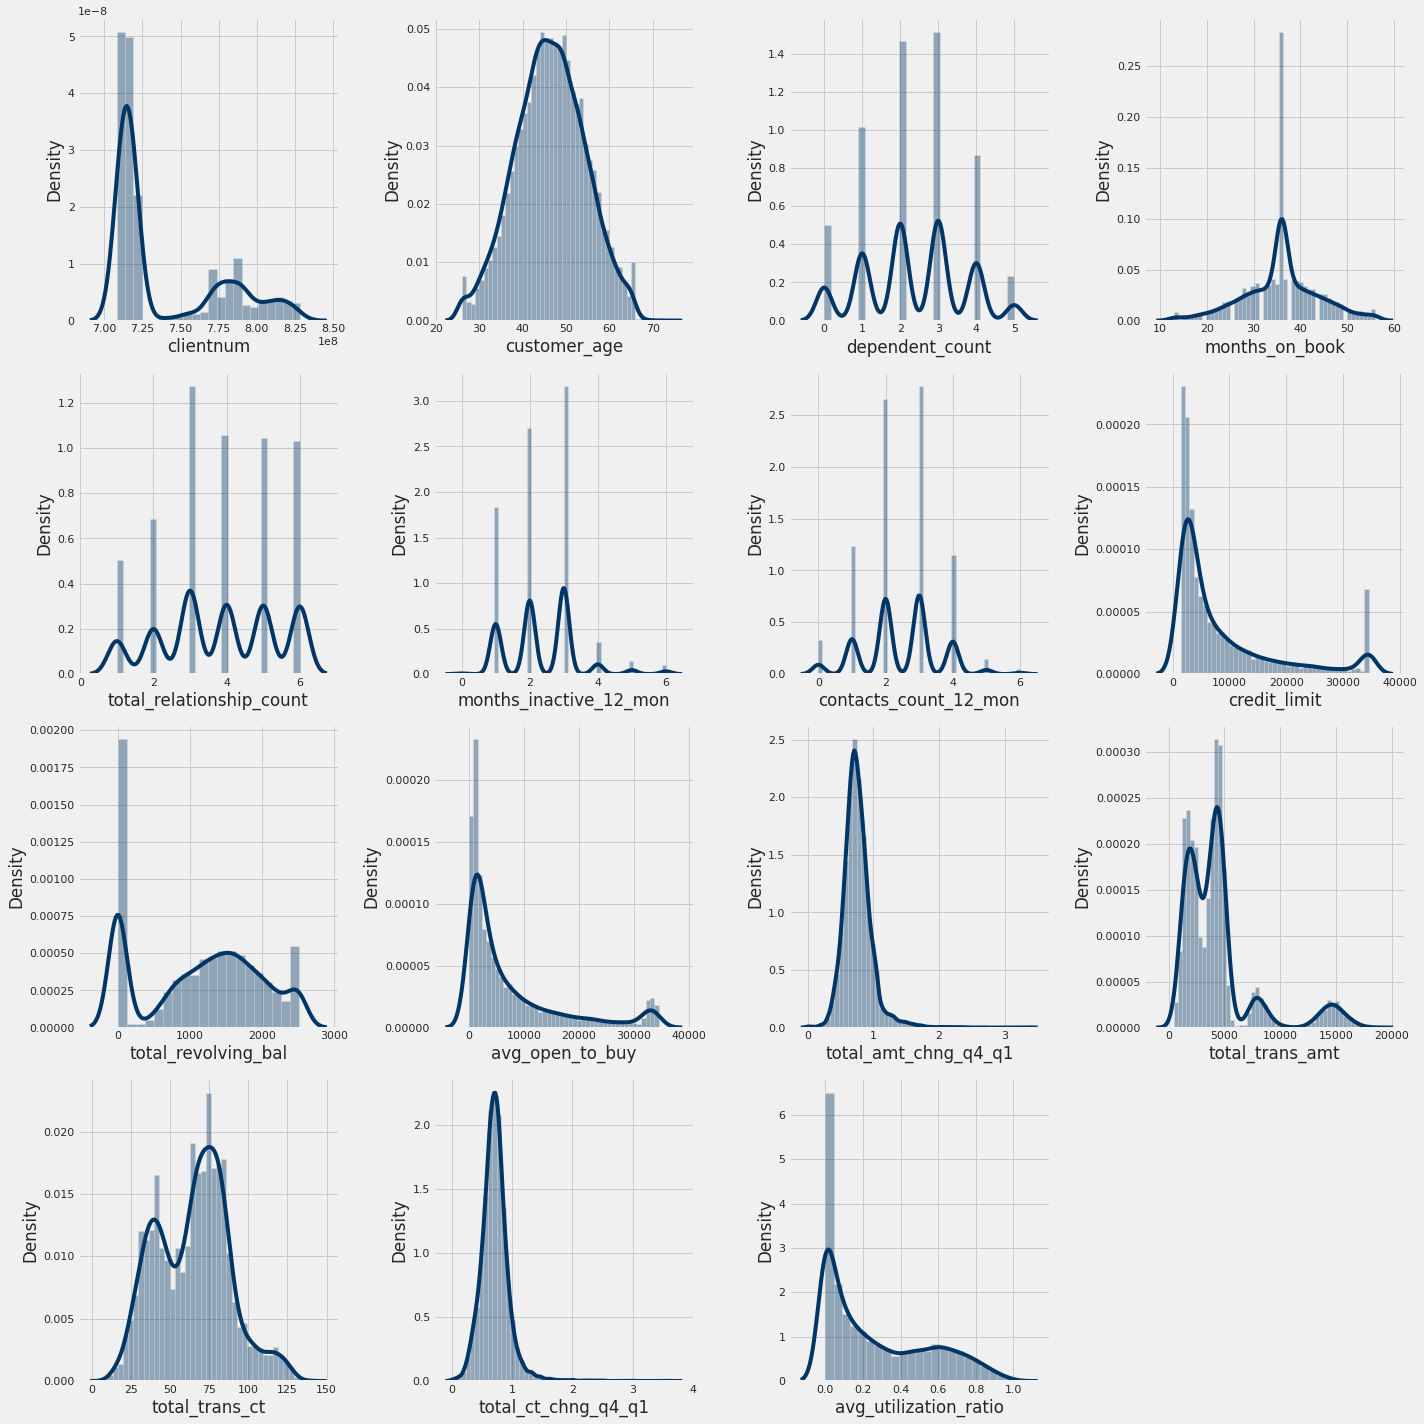

In [11]:
# validating the distribution form using KDE plot 
# setup figure
cols = 4
rows = 4
fig = plt.figure(figsize=(20,20))

# plotting
features = data_num
for i, col in enumerate(features):
    ax = fig.add_subplot(rows, cols, i+1)
    sns.distplot(x=data[col], color=palette[0], ax=ax)
    plt.xlabel(col)
fig.tight_layout()
plt.show()

Most of the feature have a skew distribution, lets see in 4 focused features below.

**4 focused features**

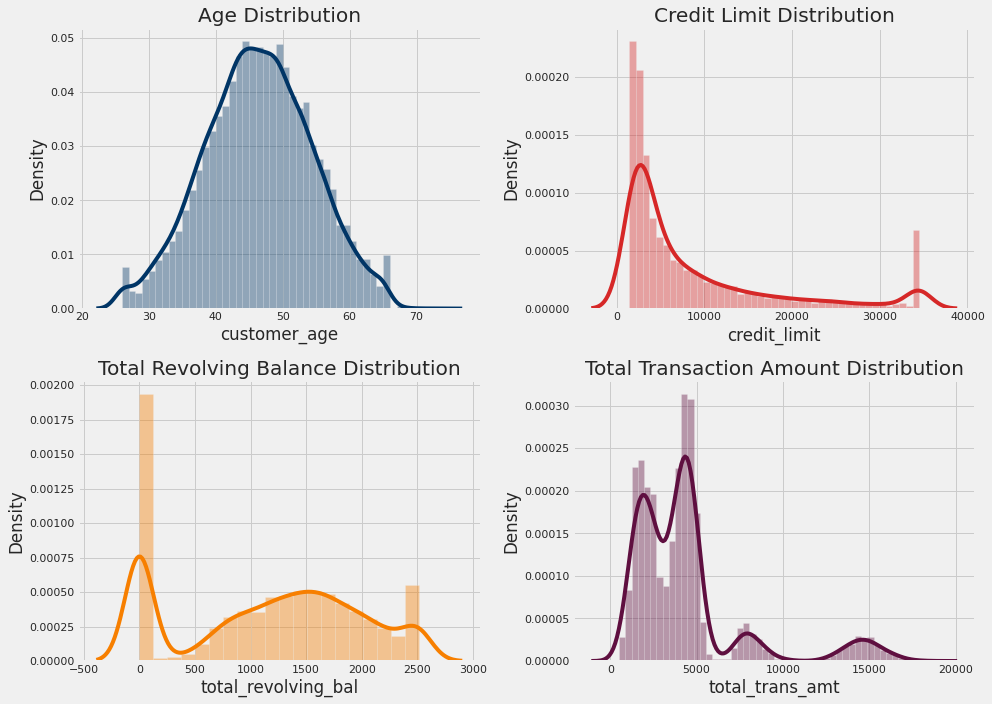

In [12]:
f, ax = plt.subplots(2,2, figsize=(14,10))

g = sns.distplot(data['customer_age'], ax=ax[0,0], color='#003566')
ax[0,0].set_title('Age Distribution')

g = sns.distplot(data['credit_limit'], ax=ax[0,1], color='#d62828')
ax[0,1].set_title('Credit Limit Distribution')

g = sns.distplot(data['total_revolving_bal'], ax=ax[1,0], color='#f77f00')
ax[1,0].set_title('Total Revolving Balance Distribution')

g = sns.distplot(data['total_trans_amt'], ax=ax[1,1], color='#5f0f40')
ax[1,1].set_title('Total Transaction Amount Distribution')

plt.tight_layout()
plt.show()

**Observation**
- `customer_age` with normal distribution, and high density at 40-50 y.o.
- `credit_limit` with a positive skew, mostly distributed under 10k.
- `total_revolving_bal` with a positive skew, and the balance highly distributed in the value < 500, followed by a range of 500-2500.
- `total_trans_amt` with a positive skew, and the amount (last 12 months) was highly distributed at < 5k.

## Univariate Analysis Categorical

In [13]:
# the univariate categoric visualization function
def cat_visual(df, feat, hue):
    df1 = df.groupby(feat)[hue].value_counts(normalize=True)                 # data
    df1 = df1.mul(100).rename('percent').reset_index()
    
    g = sns.catplot(x=feat, y='percent', hue=hue, kind='bar',                # figure
                  data=df1, height=8, aspect=11/8, palette=palette) 
    g.ax.set_ylim(0,100)
    
    for p in g.ax.patches:                                                   # percentage
        txt = str(p.get_height().round(2)) + '%'
        txt_x = p.get_x() 
        txt_y = p.get_height()
        g.ax.text(txt_x,txt_y,txt)
        
    plt.title(label='Distribution of ' + feat.capitalize())
    plt.show()

Credit : https://stackoverflow.com/questions/34615854/seaborn-countplot-with-normalized-y-axis-per-group/59433700#59433700

**Attrition Flag, the Target**

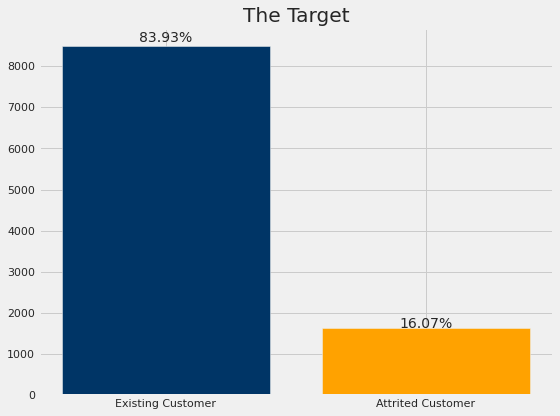

,attrition_flag,freq,percentage
0,Existing Customer,8500,83.93
1,Attrited Customer,1627,16.07


In [14]:
# the target data
attrition = data_cat['attrition_flag'].value_counts().reset_index()                           
attrition.columns = ['attrition_flag', 'freq']
attrition['percentage'] = round((attrition['freq']/attrition['freq'].sum())*100,2)

# the visualization
plt.figure(figsize=(8, 6))                                                                         
graph = plt.bar(attrition.iloc[:,0], attrition.iloc[:,1],     
                color=palette)
plt.title(label='The Target')

# loop for the %-age
i = 0
for p in graph:                                   
    width = p.get_width()                         
    height = p.get_height()                       
    x, y = p.get_xy()                             
    plt.text(x+width/2, y+height*1.01, str(attrition.percentage[i])+'%', ha='center')
    i += 1
plt.tight_layout()
plt.show()
attrition

The target shows an attrition rate dominated by `Existing Customers 84%` a.k.a retained customers, so the data is imbalanced.

Let's see the distribution of the target in each categorical feature.

**Gender**

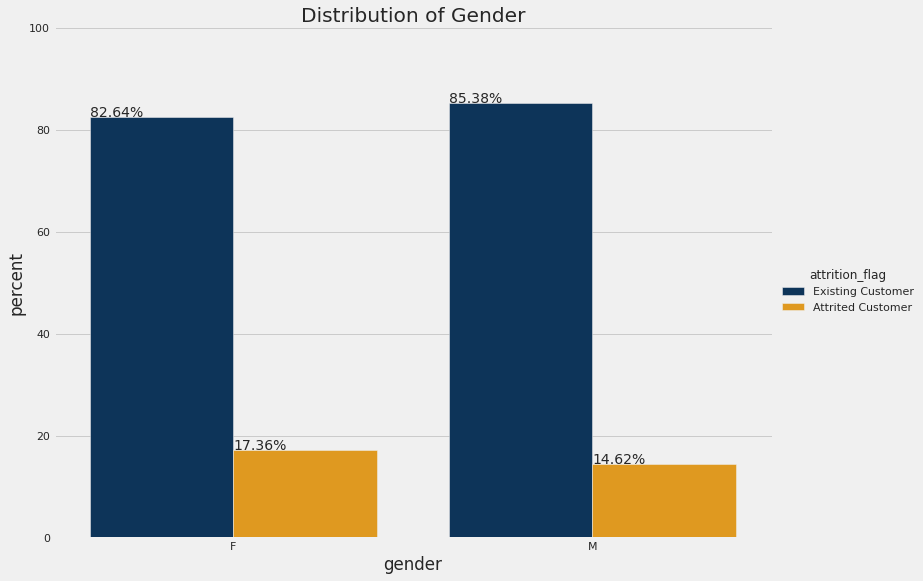

In [15]:
cat_visual(data_cat, 'gender', 'attrition_flag')

The customer's gender is dominated by the female (F) 53%, with the highest churn percentage.

**Education Level**

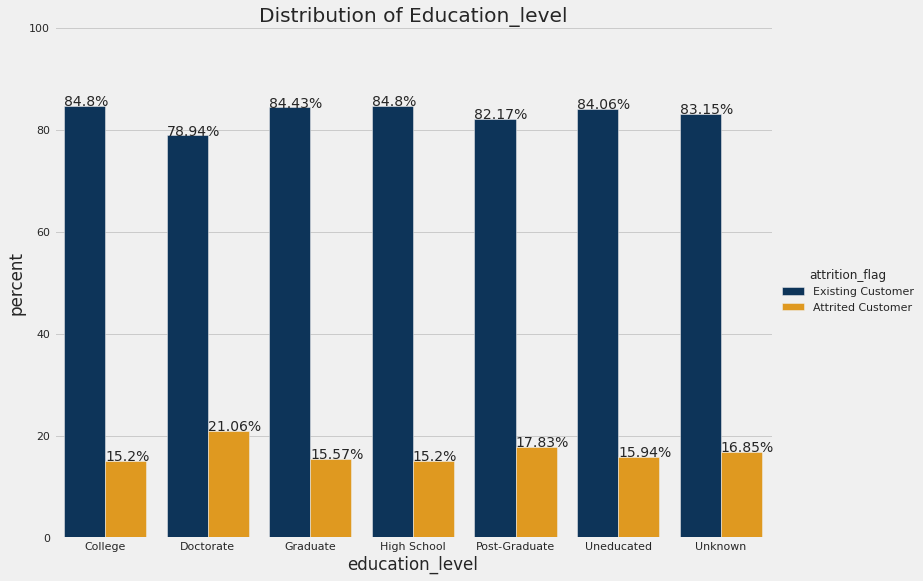

In [16]:
cat_visual(data_cat, 'education_level', 'attrition_flag')

- Graduated customer dominating in education_level.
- Doctorate customer has the highest churn (Attrited Customer) with 20.2% of the portion.
- Unknown value detected, presumably due to unwillingness to fill in the education level.

**Marital Status**

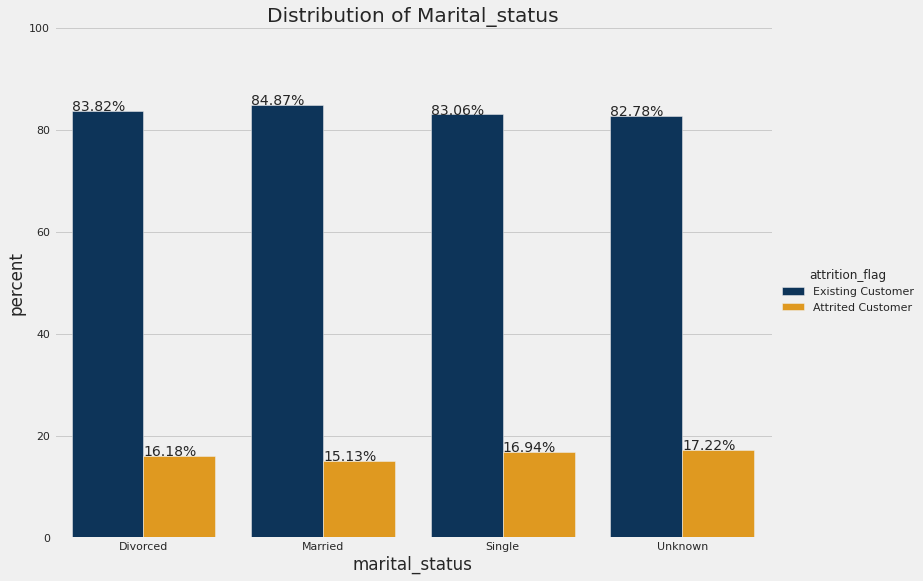

In [17]:
cat_visual(data_cat, 'marital_status', 'attrition_flag')

- Married customer is the highest, while divorced customer is the lowest but with a higher churn rate rather than the others.
- Unknown value detected, presumably due to unwillingness to fill in the marital status.

**Income Category**

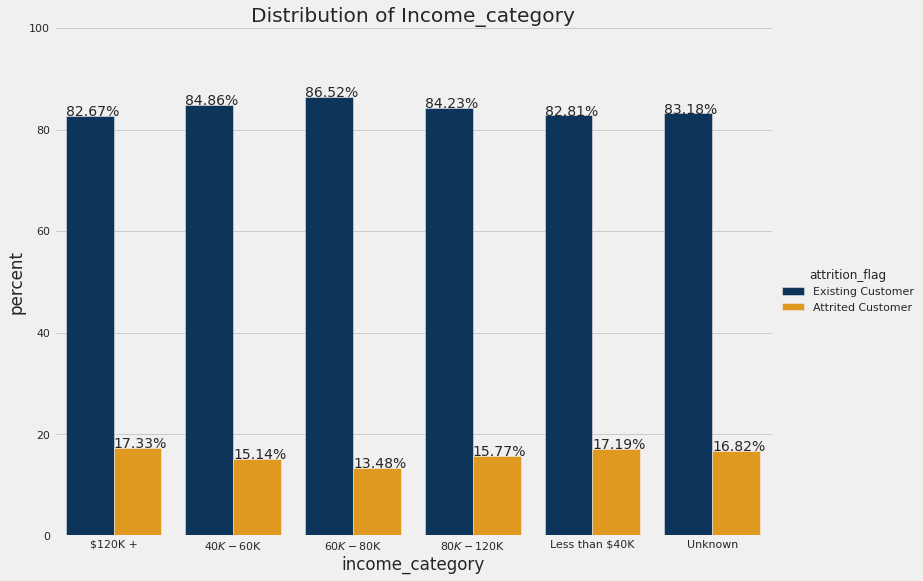

In [18]:
cat_visual(data_cat, 'income_category', 'attrition_flag')

- The most customer has income less than $40K, and be the highest churn rate category.
- An unknown value was found, presumably due to unwillingness to fill in the income.

**Card Category**

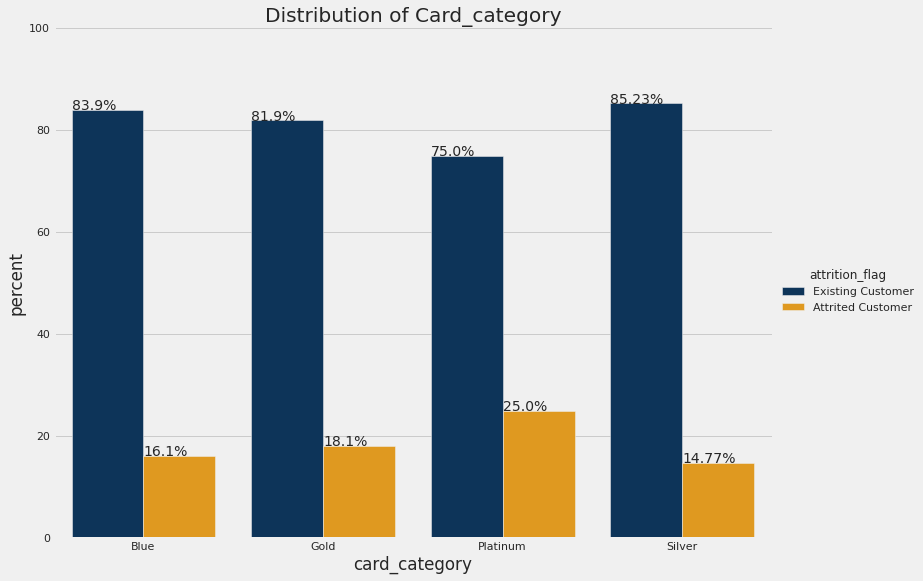

In [19]:
cat_visual(data_cat, 'card_category', 'attrition_flag')

- Most of the customers are Blue card users.
- Gold and Platinum are high-service cards due to the benefit, surprisingly it also has churned customers.

## Multivariate Analysis 
Check the corresponding value between two features. The **positive value** indicate a **positive correlation**, assuming X and Y feature, it means the X tend to be large when Y is large and small when Y is small. The **negative value** means the opposite.

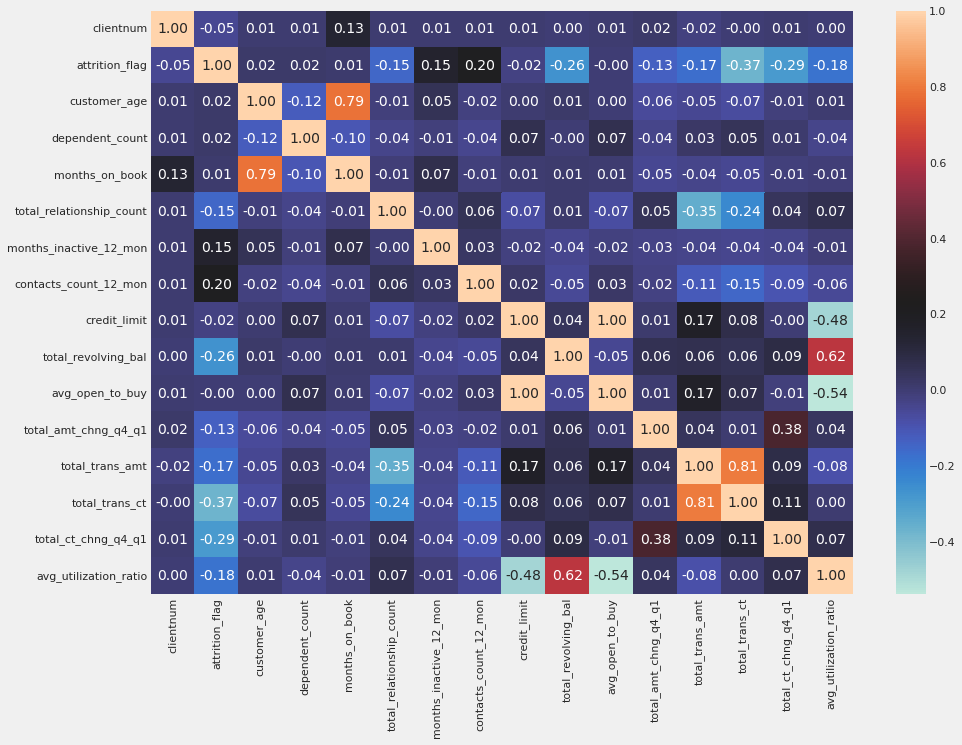

In [20]:
# replace the target to binary
data['attrition_flag'] = data['attrition_flag'].replace({'Existing Customer':0,'Attrited Customer':1}).astype('float64')

# correlation heatmap analysis
plt.figure(figsize=(14,10))
correlation = data.corr()
sns.heatmap(correlation, cmap='icefire', annot=True, fmt='.2f') 

**Observation**

4 pair features have a high-moderate (absolute) correlation value.
- `avg_open_to_buy` with `credit_limit` (1.00)
- `total_trans_ct` with `total_trans_amt` (0.81)
- `months_on_book` with `customer_age` (0.79)
- `avg_utilization_ratio` with `total_revolving_bal` (0.62)

One of the features in each pair will be **removed/dropped before the modeling**, so the model can avoid multicollinearity columns that contain redundant values.

## Deep-Dive Question
The deep-dive question is helping to get more insight from the data, beyond the standard EDA summary. The reason for doing this is to restrict the scope of the analysis and avoid pointless direction steps.

### The Question
1. What is the card that has the biggest amount of transaction in last 12 months? 
2. What is the card that has the biggest amount of revolving balance? 
3. What is the highest card by their total transaction amount that chooses to churn? How much is the total transaction amount loss due to the churned user?
4. What is the most active age group by their average transaction count?

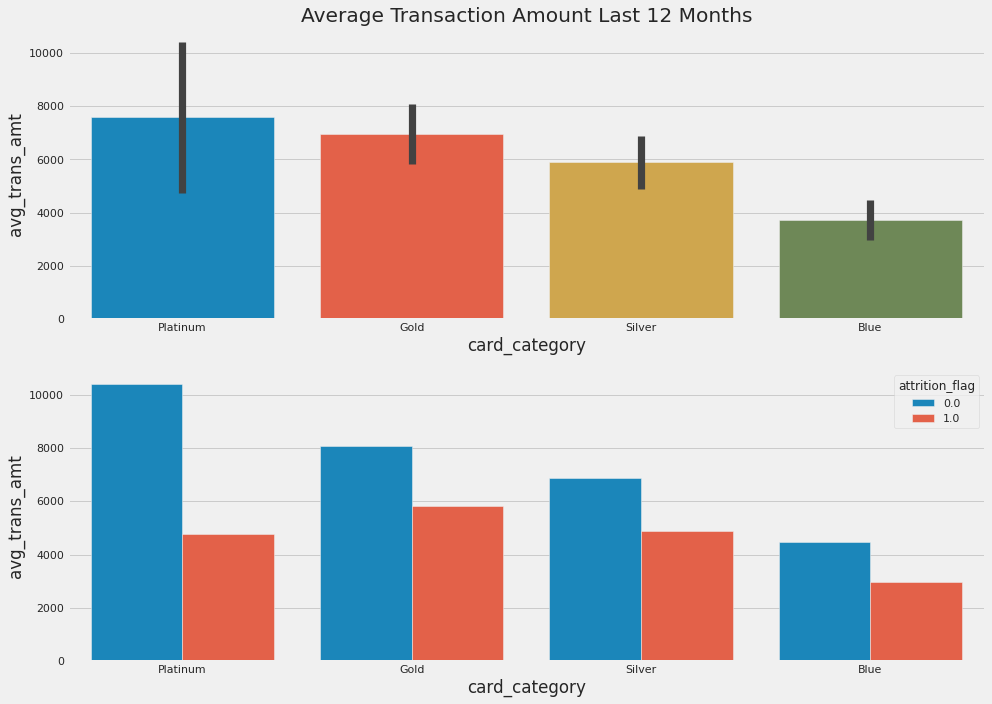

,card_category,attrition_flag,total_trans_amt,avg_trans_amt,total_card
0,Platinum,0.0,156216,10414.400000,15
1,Gold,0.0,768853,8093.189474,95
2,Silver,0.0,3255944,6883.602537,473
3,Blue,0.0,35383562,4469.314387,7917
4,Gold,1.0,122678,5841.809524,21
5,Silver,1.0,401774,4899.682927,82
6,Platinum,1.0,23779,4755.800000,5
7,Blue,1.0,4487376,2954.164582,1519


In [23]:
# 1. What is the card that has the biggest amount of transaction in last 12 months? 
tmp1 = (data.groupby(['card_category', 'attrition_flag'])
           .agg(total_trans_amt = ('total_trans_amt', 'sum'), 
                avg_trans_amt = ('total_trans_amt', 'mean'),
                total_card = ('card_category', 'count'))
           .sort_values(by=['attrition_flag','avg_trans_amt'], ascending=[True, False])
           .reset_index())

f, ax = plt.subplots(2,1, figsize=(14,10))

g = sns.barplot(data=tmp1, x='card_category', y='avg_trans_amt',ax=ax[0])
ax[0].set_title('Average Transaction Amount Last 12 Months')

g = sns.barplot(data=tmp1, x='card_category', y='avg_trans_amt', hue='attrition_flag',ax=ax[1])

plt.tight_layout()
plt.show()
tmp1

In [24]:
# Platinum card behavior
data[data.card_category == 'Platinum'].describe()

,clientnum,attrition_flag,customer_age,dependent_count,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio
count,2.000000e+01,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.0,20.000000,20.000000,20.00000,20.000000,20.000000,20.000000,20.00000,20.000000
mean,7.351706e+08,0.250000,47.500000,2.450000,36.250000,2.300000,2.250000,2.5,30283.450000,1267.950000,29015.50000,0.780100,8999.750000,86.950000,0.66620,0.043650
std,3.707450e+07,0.444262,4.784844,1.145931,5.901605,1.080935,0.850696,1.0,7698.229458,754.784213,7542.81242,0.133553,4934.726024,28.827025,0.16158,0.033003
min,7.086549e+08,0.000000,39.000000,0.000000,23.000000,1.000000,1.000000,1.0,15987.000000,0.000000,13725.00000,0.435000,1156.000000,29.000000,0.39400,0.000000
25%,7.102641e+08,0.000000,43.750000,2.000000,33.500000,1.750000,2.000000,2.0,31882.250000,577.500000,30181.50000,0.722250,5253.000000,65.000000,0.54175,0.022500
50%,7.144728e+08,0.000000,48.000000,3.000000,36.000000,2.000000,2.000000,3.0,34516.000000,1512.500000,32767.50000,0.752500,8427.000000,94.000000,0.67850,0.044500
75%,7.710428e+08,0.250000,51.000000,3.000000,41.250000,3.000000,3.000000,3.0,34516.000000,1808.750000,33044.75000,0.866500,13881.250000,107.250000,0.76725,0.055250
max,8.238482e+08,1.000000,56.000000,4.000000,46.000000,5.000000,4.000000,4.0,34516.000000,2262.000000,34516.00000,0.988000,16712.000000,127.000000,1.07100,0.141000


In [25]:
# Platinum user - Churn
data[(data.card_category == 'Platinum') & (data.attrition_flag == 1)].describe()

,clientnum,attrition_flag,customer_age,dependent_count,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio
count,5.000000e+00,5.0,5.000000,5.00000,5.000000,5.00000,5.000000,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,7.130629e+08,1.0,49.400000,2.20000,36.000000,2.80000,2.600000,3.20000,24997.400000,263.400000,24734.000000,0.784800,4755.800000,60.200000,0.545600,0.010400
std,4.238023e+06,0.0,4.159327,1.48324,4.527693,1.30384,0.547723,0.83666,9281.906825,284.587948,9212.950803,0.229779,2073.952917,10.034939,0.148193,0.010644
min,7.086549e+08,1.0,43.000000,0.00000,31.000000,2.00000,2.000000,2.00000,15987.000000,0.000000,15794.000000,0.435000,2021.000000,46.000000,0.394000,0.000000
25%,7.093197e+08,1.0,48.000000,2.00000,32.000000,2.00000,2.000000,3.00000,15987.000000,0.000000,15987.000000,0.695000,3901.000000,54.000000,0.421000,0.000000
50%,7.140776e+08,1.0,51.000000,2.00000,37.000000,2.00000,3.000000,3.00000,23981.000000,193.000000,23388.000000,0.827000,4758.000000,65.000000,0.512000,0.012000
75%,7.141910e+08,1.0,51.000000,3.00000,38.000000,3.00000,3.000000,4.00000,34516.000000,531.000000,33985.000000,0.980000,5418.000000,65.000000,0.690000,0.015000
max,7.190712e+08,1.0,54.000000,4.00000,42.000000,5.00000,3.000000,4.00000,34516.000000,593.000000,34516.000000,0.987000,7681.000000,71.000000,0.711000,0.025000


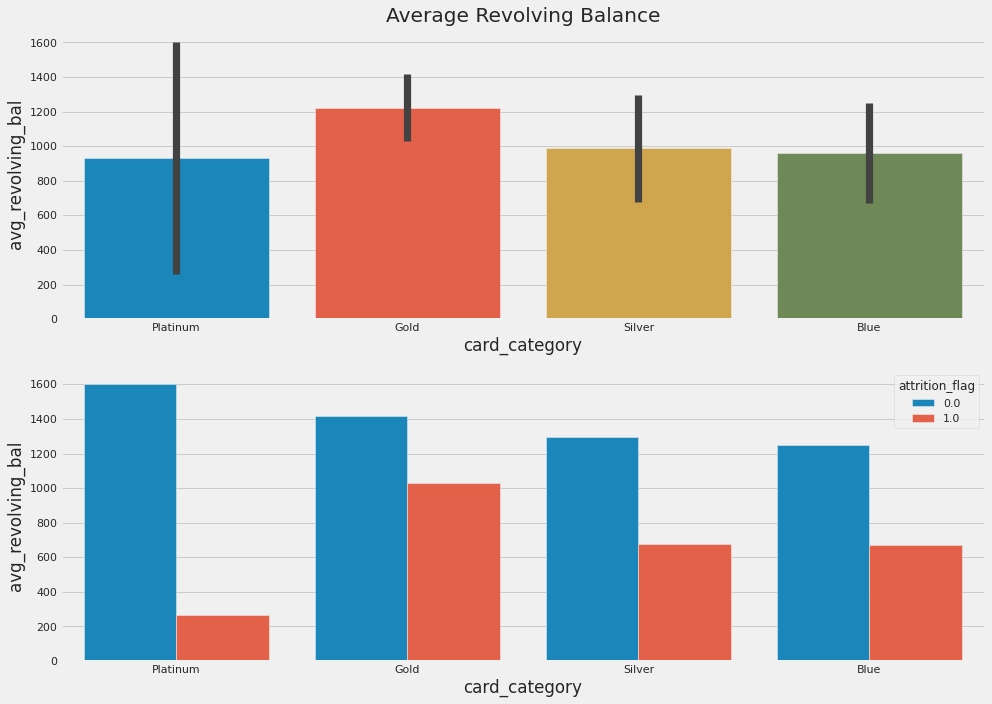

,card_category,attrition_flag,total_revolving_bal,avg_revolving_bal
0,Platinum,0.0,24042,1602.800000
1,Gold,0.0,134374,1414.463158
2,Silver,0.0,613868,1297.818182
3,Blue,0.0,9908851,1251.591638
4,Gold,1.0,21567,1027.000000
5,Silver,1.0,55534,677.243902
6,Blue,1.0,1016265,669.035550
7,Platinum,1.0,1317,263.400000


In [26]:
# 2. What is the card that has the biggest amount of revolving balance?
tmp2 = (data.groupby(['card_category', 'attrition_flag'])
           .agg(total_revolving_bal = ('total_revolving_bal', 'sum'), 
                avg_revolving_bal = ('total_revolving_bal', 'mean'))
           .sort_values(by=['attrition_flag','avg_revolving_bal'], ascending=[True,False])
           .reset_index())

f, ax = plt.subplots(2,1, figsize=(14,10))

g = sns.barplot(data=tmp2, x='card_category', y='avg_revolving_bal',ax=ax[0])
ax[0].set_title('Average Revolving Balance')

g = sns.barplot(data=tmp2, x='card_category', y='avg_revolving_bal', hue='attrition_flag' ,ax=ax[1])

plt.tight_layout()
plt.show()
tmp2

In [27]:
# Gold card behavior
data[data.card_category == 'Gold'].describe()

,clientnum,attrition_flag,customer_age,dependent_count,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio
count,1.160000e+02,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000
mean,7.381368e+08,0.181034,45.439655,2.672414,35.525862,3.008621,2.310345,2.448276,28416.370690,1344.318966,27072.051724,0.772603,7685.612069,81.517241,0.706190,0.057103
std,3.756108e+07,0.386717,6.577020,1.310664,6.618106,1.633857,1.074720,1.098179,8673.910045,774.882696,8648.962567,0.198927,4571.753917,26.713775,0.179573,0.059939
min,7.082268e+08,0.000000,29.000000,0.000000,18.000000,1.000000,1.000000,0.000000,3735.000000,0.000000,2261.000000,0.196000,966.000000,22.000000,0.214000,0.000000
25%,7.130641e+08,0.000000,41.000000,2.000000,33.000000,2.000000,1.000000,2.000000,22724.250000,813.000000,21144.250000,0.696000,4040.500000,66.750000,0.604750,0.029250
50%,7.168749e+08,0.000000,46.000000,3.000000,36.000000,2.500000,2.000000,2.000000,34516.000000,1459.000000,32441.500000,0.742000,7652.500000,82.000000,0.723000,0.050500
75%,7.729482e+08,0.000000,49.000000,4.000000,38.000000,4.000000,3.000000,3.000000,34516.000000,1952.250000,33238.500000,0.833250,9320.000000,100.250000,0.783500,0.070250
max,8.273330e+08,1.000000,63.000000,5.000000,55.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,1.975000,16328.000000,131.000000,1.250000,0.395000


In [28]:
# Gold user - Churn
data[(data.card_category == 'Gold') & (data.attrition_flag == 1)].describe()

,clientnum,attrition_flag,customer_age,dependent_count,months_on_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio
count,2.100000e+01,21.0,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
mean,7.317916e+08,1.0,43.857143,2.571429,33.904762,3.047619,2.619048,3.000000,29878.523810,1027.000000,28851.523810,0.769905,5841.809524,59.857143,0.619048,0.036286
std,3.778012e+07,0.0,6.223228,1.287301,6.155524,1.687489,0.589592,1.378405,7832.307423,1009.462233,7757.524622,0.255882,2836.813135,14.402381,0.200502,0.035452
min,7.083696e+08,1.0,32.000000,0.000000,20.000000,1.000000,1.000000,1.000000,15109.000000,0.000000,13640.000000,0.196000,1727.000000,34.000000,0.214000,0.000000
25%,7.125091e+08,1.0,41.000000,2.000000,32.000000,2.000000,2.000000,2.000000,23981.000000,0.000000,23981.000000,0.591000,2315.000000,47.000000,0.478000,0.000000
50%,7.156459e+08,1.0,44.000000,2.000000,36.000000,2.000000,3.000000,3.000000,34516.000000,897.000000,32315.000000,0.858000,6782.000000,64.000000,0.650000,0.032000
75%,7.198746e+08,1.0,47.000000,4.000000,36.000000,4.000000,3.000000,3.000000,34516.000000,1847.000000,34516.000000,0.978000,8356.000000,68.000000,0.750000,0.064000
max,8.176074e+08,1.0,59.000000,5.000000,48.000000,6.000000,3.000000,6.000000,34516.000000,2517.000000,34516.000000,1.047000,9338.000000,89.000000,0.978000,0.119000


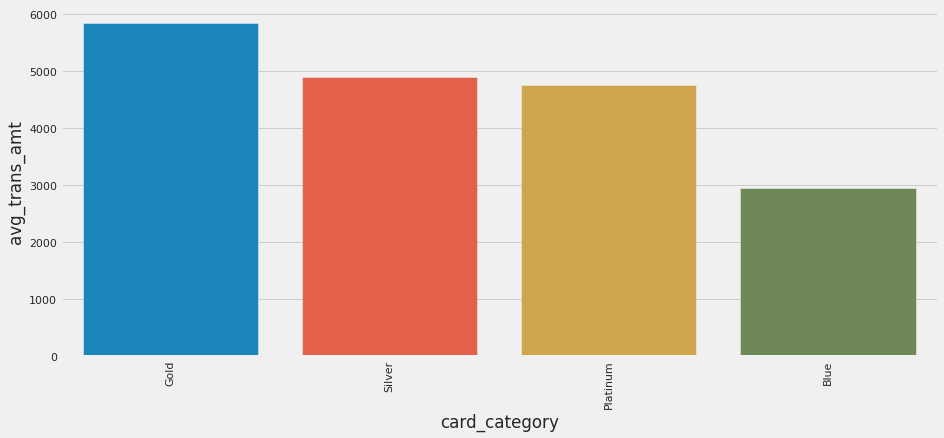

The total transaction amount loss due to the churned user : $ 5035607


,card_category,attrition_flag,total_trans_amt,avg_trans_amt,total_card
0,Gold,1.0,122678,5841.809524,21
1,Silver,1.0,401774,4899.682927,82
2,Platinum,1.0,23779,4755.800000,5
3,Blue,1.0,4487376,2954.164582,1519


In [29]:
# 3. What is the highest card by their total transaction amount that chooses to churn?
tmp = data[data['attrition_flag']==1]

tmp3 = (tmp.groupby(['card_category', 'attrition_flag'])
           .agg(total_trans_amt = ('total_trans_amt', 'sum'), 
                avg_trans_amt = ('total_trans_amt', 'mean'),
                total_card = ('card_category', 'count'))
           .sort_values(by=['attrition_flag','avg_trans_amt'], ascending=[True, False])
           .reset_index())

plt.figure(figsize=(14,6))
sns.barplot(data=tmp3,
            x='card_category',
            y='avg_trans_amt')
plt.xticks(rotation=90)
plt.show()

# How much is the total transaction amount loss due to the churned user?
print('The total transaction amount loss due to the churned user : $', tmp3.total_trans_amt.sum())
tmp3

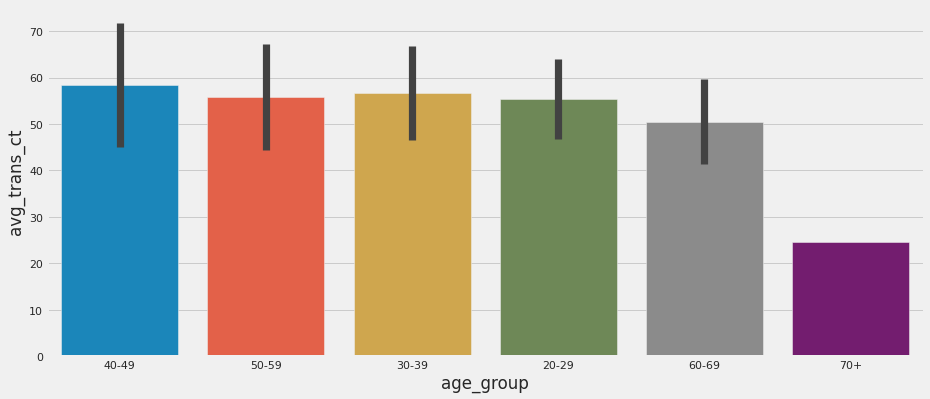

,age_group,attrition_flag,avg_trans_ct,total_trans_ct,avg_trans_amt
0,40-49,0.0,71.732383,271794,4964.264186
1,50-59,0.0,67.200241,167463,4549.117576
2,30-39,0.0,66.862658,105643,4411.262658
3,20-29,0.0,63.898876,11374,4270.971910
4,60-69,0.0,59.681917,27394,3672.237473
5,20-29,1.0,46.705882,794,4155.941176
6,30-39,1.0,46.620690,12168,3456.095785
7,40-49,1.0,45.002591,34742,3011.954663
8,50-59,1.0,44.407115,22470,3062.535573
9,60-69,1.0,41.309859,2933,2648.492958


In [31]:
# 4. What is the most active age group by their average transaction count?
def age_buckets(x): 
    if x < 30: 
        return '20-29' 
    elif x < 40: 
        return '30-39' 
    elif x < 50: 
        return '40-49' 
    elif x < 60: 
        return '50-59' 
    elif x < 70: 
        return '60-69' 
    elif x >=70: 
        return '70+' 
    else: 
        return 'other'
    
# the grouped age
tmp = data.copy()
tmp['age_group'] = tmp.customer_age.apply(age_buckets)

tmp4 = (tmp.groupby(['age_group','attrition_flag']).agg(avg_trans_ct = ('total_trans_ct', 'mean'),
                                                        total_trans_ct = ('total_trans_ct', 'sum'),
                                                        avg_trans_amt = ('total_trans_amt', 'mean'))
           .sort_values('avg_trans_ct', ascending=False)
           .reset_index())

plt.figure(figsize=(14,6))
sns.barplot(data=tmp4,
            x='age_group',
            y='avg_trans_ct')
plt.show()
tmp4

### The Answer
1. The card ranking due to the **amount of transactions** in the last 12 months is: <br> 
    - **Platinum**
    - Gold, 
    - Silver, and 
    - Blue.
    
   But in a matter of **churn customers**, the rank is: <br>
   - **Gold**, 
   - Silver, 
   - Platinum, and 
   - Blue.

2. The card ranking due to the **amount of revolving balance** is:<br>
    - **Gold**,
    - Platinum,
    - Silver, and
    - Blue.

    However, the **Gold** also get the first place in a matter of **churn customers**.
    

3. The **Gold** card become the **most valuable card** in a matter of churn case. By the total of the transaction amount and the revolving balance. 


4. The top 3 active users by the average transaction count is: <br>
    - **40-49 age group**
    - 50-59 age group
    - 30-39 age group

# Data Preprocessing

## Split Data
Before doing the preprocessing, split the data to train and test to hold out the original data as a test set and prevent the data leakage. Split the data into a train-test set, with a 70:30 portion.

In [32]:
data_features = data.iloc[:,2:]    
data_target = data.iloc[:,1]      

# train : test = 70 : 30
X_train, X_test, y_train, y_test = train_test_split(data_features, data_target, test_size=0.3, random_state=42)

# check the data after split train-test
print('data_X shape\t:', data_features.shape)
print('data_y shape\t:', data_target.shape)
print()
print('X_train shape\t:', X_train.shape)
print('y_train shape\t:', y_train.shape)
print()
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

data_X shape	: (10127, 19)
data_y shape	: (10127,)

X_train shape	: (7088, 19)
y_train shape	: (7088,)

X_test shape: (3039, 19)
y_test shape: (3039,)


## Missing Values Handling

In [33]:
data.isnull().sum()

clientnum                   0
attrition_flag              0
customer_age                0
gender                      0
dependent_count             0
education_level             0
marital_status              0
income_category             0
card_category               0
months_on_book              0
total_relationship_count    0
months_inactive_12_mon      0
contacts_count_12_mon       0
credit_limit                0
total_revolving_bal         0
avg_open_to_buy             0
total_amt_chng_q4_q1        0
total_trans_amt             0
total_trans_ct              0
total_ct_chng_q4_q1         0
avg_utilization_ratio       0
dtype: int64

There is no NULL data in the dataset, but we detected an 'Unknown' expression at the EDA step. It is found in the `education_level`, `marital_status`, and `income_category` columns.

In [34]:
print("Observations with Unknown values in at least one of the attributes: {} out of {}".format(
    (data[(data["education_level"] == "Unknown") | 
          (data["marital_status"] == "Unknown") | 
          (data["income_category"] == "Unknown")].shape[0]),
    data.shape[0]))

Observations with Unknown values in at least one of the attributes: 3046 out of 10127


- By the portion above, if treated as a missing value it will cause a **loss of information**. 
- So it will be treated as another category and labeled as zero in the encoding step.

## Multicollinearity Study
Follow up from multivariate analysis in EDA. Drop the multicollinearity features.

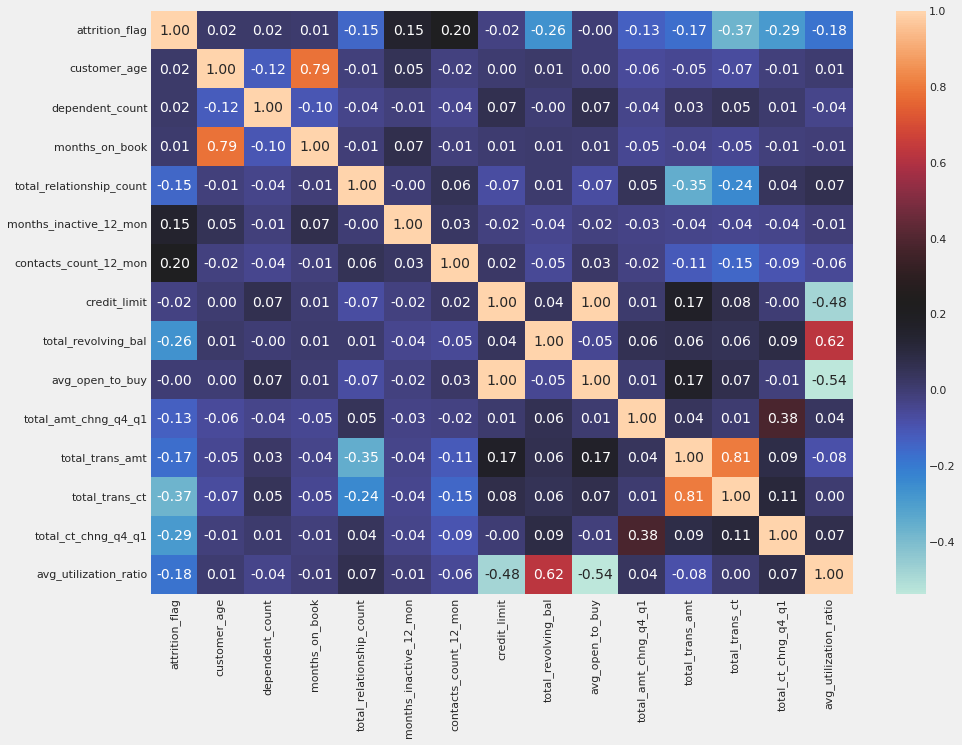

In [35]:
# check multicollinearity by using correlation heatmap 
plt.figure(figsize=(14,10))
correlation = data.iloc[:,1:].corr()
sns.heatmap(correlation, cmap='icefire', annot=True, fmt='.2f')

The each pairs that has a high absolute correlation value (above 0.7)
- `months_on_book` with `customer_age` (0.79)
- `avg_open_to_buy` with `credit_limit` (1.00)
- `total_trans_ct` with `total_trans_amt` (0.81)

After the consecutive trial-error step, we choose to drop `months-on-books`, `avg_open_to_buy`, and `total_trans_ct`.

In [36]:
# drop one feature from each pairs
X_train = X_train.drop(['months_on_book', 'avg_open_to_buy', 'total_trans_ct'], axis=1)

columns_name = X_train.columns
X_test = X_test[columns_name]

## Encoding
The encoding step divided into two type, ordinal encoding and one-hot encoding. 
- Ordinal encoding for `education_level`, `income_category`, and `card_category` due to their natural rank ordering values. 
- One-hot encoding for `gender`, and `marital_status` due to their non-ordering values.

In [39]:
# ordinal encoding
X_train['education_level'] = X_train['education_level'].replace({'Unknown':0, 'Uneducated':1, 'High School':2,
                                                                 'College':3, 'Graduate':4, 'Post-Graduate':5, 'Doctorate':6})
X_train['income_category'] = X_train['income_category'].replace({'Unknown':0, 'Less than $40K':1, '$40K - $60K':2,
                                                                 '$60K - $80K':3, '$80K - $120K':4, '$120K +':5,})
X_train['card_category'] = X_train['card_category'].replace({'Blue':0, 'Silver':1, 'Gold':2, 'Platinum':3})

# label encoding
X_train['gender'] = X_train['gender'].replace({'F':1,'M':0})
X_train['marital_status'] = X_train['marital_status'].replace({'Unknown':0,'Divorced':1,'Married':2,'Single':3})

In [40]:
# ordinal encoding
X_test['education_level'] = X_test['education_level'].replace({'Unknown':0, 'Uneducated':1, 'High School':2,
                                                               'College':3, 'Graduate':4, 'Post-Graduate':5, 'Doctorate':6})
X_test['income_category'] = X_test['income_category'].replace({'Unknown':0, 'Less than $40K':1, '$40K - $60K':2,
                                                               '$60K - $80K':3, '$80K - $120K':4, '$120K +':5,})
X_test['card_category'] = X_test['card_category'].replace({'Blue':0, 'Silver':1, 'Gold':2, 'Platinum':3})

# label encoding
X_test['gender'] = X_test['gender'].replace({'F':1,'M':0})
X_test['marital_status'] = X_test['marital_status'].replace({'Unknown':0,'Divorced':1,'Married':2,'Single':3})

## Oversample SMOTE
As we know from the EDA, the data is imbalance, Existing vs Attrited Customer, 84 % vs 16 %. The imbalance data will give a bad result into ML, so we need avoid it by using SMOTE method (Synthetic Minority Oversampling TEchnique) on training data.

In [41]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))
  
# SMOTE
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)
  
print('After OverSampling, the shape of train_X: {}'.format(X_train.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train == 0)))

Before OverSampling, counts of label '1': 1131
Before OverSampling, counts of label '0': 5957 

After OverSampling, the shape of train_X: (11914, 16)
After OverSampling, the shape of train_y: (11914,) 

After OverSampling, counts of label '1': 5957
After OverSampling, counts of label '0': 5957


# Modeling
The model candidates are:
- Logistic Regression
- KNN
- Decision Tree
- Random Forest

Compare their evaluation to get the best model, and tune it to increase its classification performance.

**Logistic Regression Classifier as Baseline**

In [42]:
clf = LogisticRegression(random_state=42)

# fit & preds
lr_model = clf.fit(X_train, y_train)
preds = lr_model.predict(X_test)

scores = [["Precision score", precision_score(y_test, preds, pos_label = 1)],
          ["Recall score", recall_score(y_test, preds, pos_label = 1)],
          ["F1 score", f1_score(y_test, preds, pos_label = 1)]]

pd.DataFrame(scores, columns=["Metric", "Score"])

,Metric,Score
0,Precision score,0.331584
1,Recall score,0.637097
2,F1 score,0.436163


**KNN Classifier**

In [43]:
clf = KNeighborsClassifier()

# fit & preds
knn_model = clf.fit(X_train, y_train)
preds = knn_model.predict(X_test)

scores = [["Precision score", precision_score(y_test, preds, pos_label = 1)],
          ["Recall score", recall_score(y_test, preds, pos_label = 1)],
          ["F1 score", f1_score(y_test, preds, pos_label = 1)]]

pd.DataFrame(scores, columns=["Metric", "Score"])

,Metric,Score
0,Precision score,0.521978
1,Recall score,0.766129
2,F1 score,0.620915


**Decision Tree Classifier**

In [44]:
clf = DecisionTreeClassifier(random_state=42)

# fit & preds
dt_model = clf.fit(X_train, y_train)
preds = dt_model.predict(X_test)

scores = [["Precision score", precision_score(y_test, preds, pos_label = 1)],
          ["Recall score", recall_score(y_test, preds, pos_label = 1)],
          ["F1 score", f1_score(y_test, preds, pos_label = 1)]]

pd.DataFrame(scores, columns=["Metric", "Score"])

,Metric,Score
0,Precision score,0.714286
1,Recall score,0.796371
2,F1 score,0.753098


**Random Forest Classifier**

In [45]:
clf = RandomForestClassifier(random_state=42)

# fit & preds
rf_model = clf.fit(X_train, y_train)
preds = rf_model.predict(X_test)

scores = [["Precision score", precision_score(y_test, preds, pos_label = 1)],
          ["Recall score", recall_score(y_test, preds, pos_label = 1)],
          ["F1 score", f1_score(y_test, preds, pos_label = 1)]]

pd.DataFrame(scores, columns=["Metric", "Score"])

,Metric,Score
0,Precision score,0.811133
1,Recall score,0.822581
2,F1 score,0.816817


**Random Forest model** overcome the other model, so we choose it as best model.

## Hyperparameter Tuning
We need to build a model with **high precision and sensitivity in predicting churn**, therefore we choose **the f1 score** (the precision & recall harmonic averages) as the metric evaluation.
- High precision to minimize user-churn prediction errors, so that **the distribution of churn treatment can be right on target**.
- High sensitivity to minimize churn detection errors for users, so **the prediction of potential churn on new customers (new data) can be very sensitive**.

Random Forest hyperparameter tuning:
- **max_depth**, defined as the longest path between the root node and the leaf node. It can limit up the depth of every tree in the random forest, in order to control the overfitting in training set.
- **max_features**, it allows the random forest to take variables in individual run. These are the maximum number of features Random Forest is allowed to try in individual tree.
- **n_estimators**, this is the number of trees to construct the forest. The higher value give a stable output but can cause a slower code.

Source : https://www.analyticsvidhya.com/blog/2020/03/beginners-guide-random-forest-hyperparameter-tuning/

In [46]:
%%time
# define the model
model = RandomForestClassifier(random_state=42)  

# defining the parameter values
params = {
    'max_depth' : [30, None],
    'n_estimators': [250, 500],
    'max_features': [0.5, 'sqrt']
}

# scoring
scorer = make_scorer(f1_score, pos_label=1)

# fit to get optimum hyperparameters
optimize_hparams = GridSearchCV(model, params, cv=5, scoring=scorer)    # initiate grid
optimize_hparams.fit(X_train, y_train)                                  # run the grid

CPU times: user 5min 59s, sys: 660 ms, total: 5min 59s
Wall time: 6min 3s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [30, None], 'max_features': [0.5, 'sqrt'],
                         'n_estimators': [250, 500]},
             scoring=make_scorer(f1_score, pos_label=1))

## Model Performance Evaluation


In [47]:
# the compact results
cv_rf = pd.DataFrame(optimize_hparams.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
tmp_cv_rf = cv_rf[retain_cols].sort_values('rank_test_score')
tmp_cv_rf.head(2)

,params,mean_test_score,rank_test_score
2,"{'max_depth': 30, 'max_features': 'sqrt', 'n_e...",0.966024,1
6,"{'max_depth': None, 'max_features': 'sqrt', 'n...",0.966024,1


In [48]:
optimize_hparams.best_estimator_

RandomForestClassifier(max_depth=30, max_features='sqrt', n_estimators=250,
                       random_state=42)

There are 2 best parameter for the model, but due to the `best_estimator_` the best one is:<br>
**RandomForestClassifier(max_depth=30, max_features='sqrt', n_estimators=250, random_state=42)**

**Classification Report**

Be careful to correctly read the recall and precision, look at `Attrited Customer` row (the positive class `1`), because the recall and precision for the negative class have a different interpretation.

In [49]:
# best model, fit & predict
rf_best = optimize_hparams.best_estimator_
rf_best.fit(X_train, y_train)
y_pred = rf_best.predict(X_test)

# the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.96      0.96      2543
         1.0       0.81      0.82      0.82       496

    accuracy                           0.94      3039
   macro avg       0.89      0.89      0.89      3039
weighted avg       0.94      0.94      0.94      3039



The classification report:
- `81 % precision score`, means out of 100 predicted churn, 81 of them actually churn. So we can say that **the model is quite precise to predicts the churn**.
- `82 % recall score`, means the model succesfully predict 82 from 100 actual churned person. So we can say **the model is quite senstive to detect churn**.

With a high precision and sensitivity, the model can be sensitve to predicting churn. So we can prevent the future customer form churning.

**Confusion Matrix and Class Prediction Error**

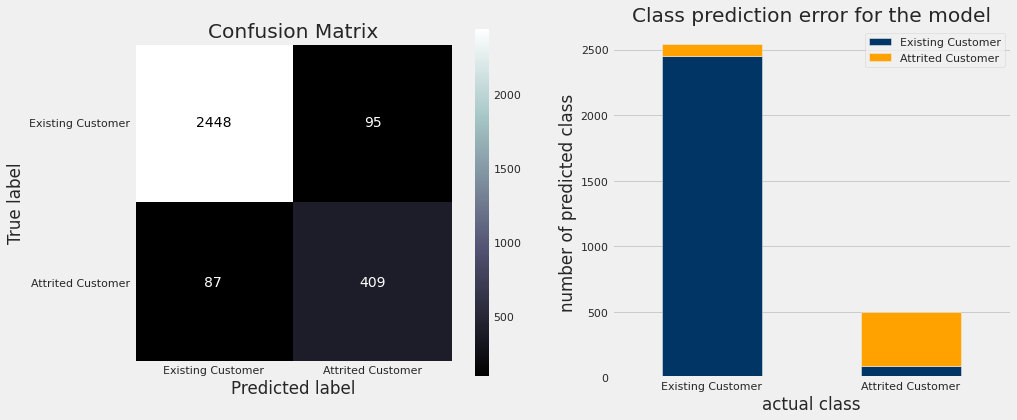

In [50]:
# visualization of confusion matrix and its bar version
classifier = rf_best
target_labels = ['Existing Customer','Attrited Customer']
fig, axs = plt.subplots(1, 2, figsize=(14,6))

# confusion matrix
cnf_mat = plot_confusion_matrix(classifier, X_test, y_test, labels=[0,1], 
                                display_labels=target_labels, ax=axs[0], cmap='bone')
axs[0].set_title('Confusion Matrix')
axs[0].grid(False)

# class prediction error
cnf_mat_df = pd.DataFrame(cnf_mat.confusion_matrix, columns=target_labels, index=target_labels)
cnf_mat_df.plot.bar(stacked=True, rot=False, 
                        xlabel='actual class', ylabel='number of predicted class', ax=axs[1], color=palette)
axs[1].set_title('Class prediction error for the model')
axs[1].grid(axis='x')

The interpretation of the confusion matrix results for the tuned model :
- True negative : correctly predicts 2448 customers as non-churn.
- **False positive** : predicts as many as 95 customers' churns, but in reality, they do not churn.
- **False negative** : predict as many as 87 customers as not churn, but in fact, churn.
- True positive : correctly predicted 409 customers as churn.

According to the model requirement, **the false case** both positive and negative will **become the model concern**.

When its value gets minimized (smaller in every trial and error), we can say that the model has reached the goal to be **high precision and sensitivity model**.

# Model Interpretability

## Permutation Feature Importance 
**What features have the biggest impact on predictions?**<br>
Permutation feature importance is a model inspection method that tries to answer the question above. Its defined to be the decrease in a model score when a single feature value is randomly shuffled. This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature.

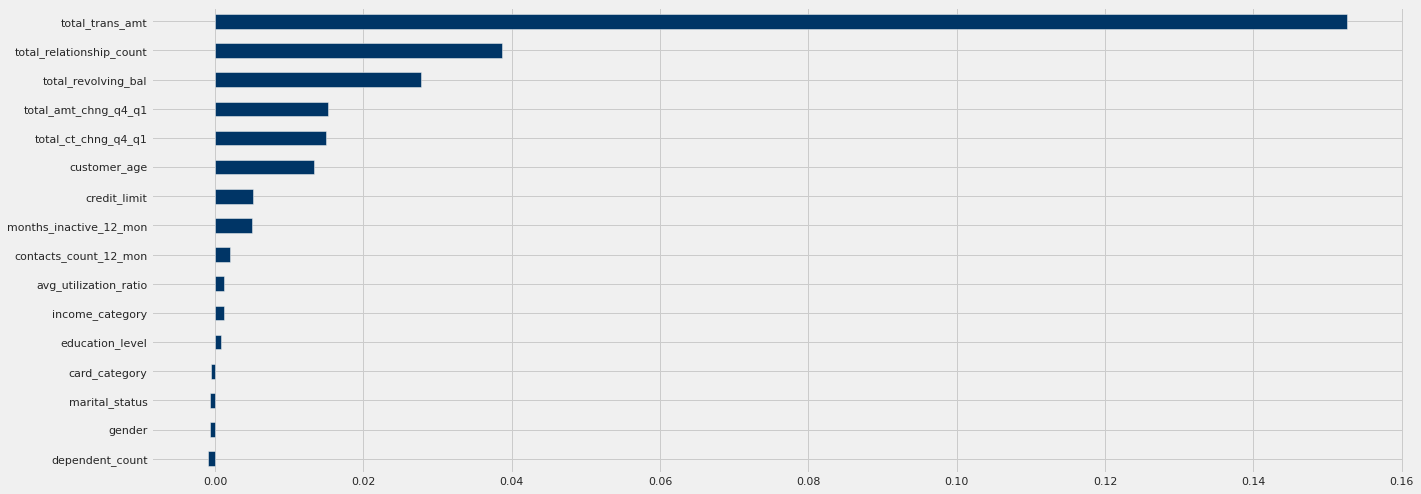

In [51]:
# calculating the result
result = permutation_importance(rf_best, X_test, y_test, n_repeats=10, random_state=42)
forest_importances = pd.Series(result.importances_mean, index=[i for i in X_test.columns])

# visualize the result
forest_importances.sort_values(ascending=True).plot(kind='barh', color=palette[0])

The top 3 important features : 
- `total_trans_amt`
- `total_relationship_count`
- `total_revolving_bal`

**It appears `total_trans_amt` is the most important feature and the impactfull variables in predictions**. The values towards the top are the most important features, and those towards the bottom matter least.

Negative values for permutation importances happens when the feature didn't matter (should have had an importance close to 0), but random chance caused the predictions on shuffled data to be more accurate.

## SHAP 
SHAP Values (an acronym from SHapley Additive exPlanations) break down a prediction to show the impact of each feature.  SHAP only tells what the model is doing within the context of the data on which it has been trained.

**Local Interpretability** 

Simply, SHAP method will **break down how the model works for an individual prediction.**
We will look at SHAP values for a single row of the dataset (we arbitrarily chose row 3). For context, we'll look at the raw predictions before looking at the SHAP values.

In [52]:
# the raw predictions 
row_to_show = 3                                 # the row number of customer data
data_for_prediction = X_test.iloc[row_to_show]  
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

rf_best.predict_proba(data_for_prediction_array)

array([[0.744, 0.256]])

The shap_values object above is a list with two arrays. The first array is the SHAP values for a negative outcome (don't leave the services), and the second array is the list of SHAP values for the positive outcome (leave the services). 

We typically think about predictions in terms of **the prediction of a positive outcome**, so we'll **pull out SHAP values for positive outcomes (shap_values[1])**. So the example above is

   - **the user is 26% likely tend to churn or leave the services.**

Now, we'll move onto the code to get SHAP values for that single prediction.

In [53]:
# create object that can calculate shap values
explainer = shap.TreeExplainer(rf_best)

# calculate shap values
shap_values = explainer.shap_values(data_for_prediction)

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

Feature values causing increased predictions are in pink, feature values decreasing the prediction are in blue, and their visual size shows the magnitude of the feature's effect. 
- We predicted 0.26, whereas the base_value is 0.4998. 
- The biggest impact comes from `total_revolving_bal` being 1516.

In [54]:
# shap function to breakdown the individual customer prediction
def cust_risk_factors(cust_data):
    model = rf_best
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(cust_data)
    shap.initjs()
    return shap.force_plot(explainer.expected_value[1], shap_values[1], cust_data)

In [55]:
cust_risk_factors(X_test.iloc[12])

In [56]:
cust_risk_factors(X_test.iloc[34])

**Global Interpretability**

SHAP summary plots give us **a birds-eye view of feature importance and what is driving it across the population**.

In [57]:
N = X_test.shape[0]
e = 0.05
slovin = N / (1+ N * e**2)
print(f'The sample of X_test that is used in the SHAP summary plot is {round(slovin)} rows')

The sample of X_test that is used in the SHAP summary plot is 353 rows


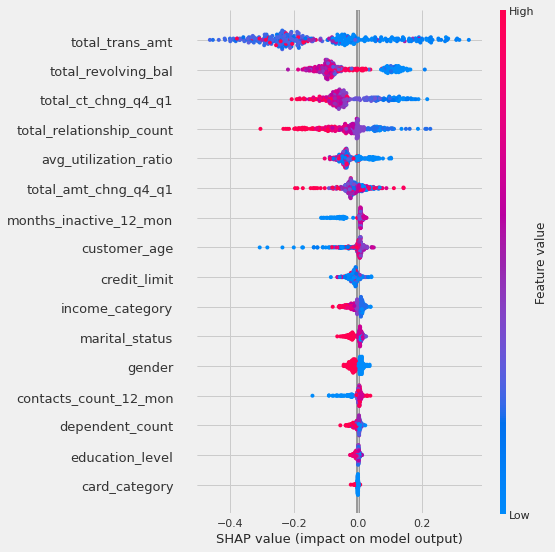

In [58]:
small_val_X = X_test.sample(n=353, random_state=42)
explainer = shap.TreeExplainer(rf_best)
shap_values = explainer.shap_values(small_val_X)
shap.summary_plot(shap_values[1], small_val_X)

Every row of the dataset appears as its dot, and it has three characteristics:
- The vertical placement indicates which feature is being shown.
- The color indicates whether the feature value for that row of the dataset was high or low.
- Horizontal location indicates whether the impact of that value results in a larger or smaller prediction.

In a feature with high-density SHAP values, the dots are stacked vertically. 

For example, the point in the upper right was for a customer with low `total_trans_amt`, increasing the churn prediction by higher than 0.3. 

**Observation**
- The `total_trans_amt` seems can give an impact, both increasing and decreasing the prediction.
- The lower `total_revolving_bal` value increases the prediction. But in another case, the higher value will increase the prediction. 
- The higher the `total_relationship_count` means the more number of products held by the customer, it is decreasing the prediction by 0.1 to 0.2.
- The lower `months_inactive_12_mon` of the customer, decreases the prediction. It also applies in `contacts_count_12_mon` and `customer_age`.
- The model seems to ignore the `card_category` feature.

# Conclusion 

**EDA**
- Platinum users became the most valuable card due to its average transaction in the last 12 months. 
- Gold card users became the top valuable churned card based on their average transaction amount in the last 12 months.
- The customer is in the range of 40-49 y.o. became the most active users.

**Modeling**
- The best predictive model is Random Forest with tuned parameters, F1 score of 82%.
- Through the SHAP method, we can identify the predicted customer at risk and their specific reasons.

**Actionable Insight**
- Review the user's profile to learn more about their preferences and previous service interactions.
- Accommodate their needs by providing the latest offers and services.
- Focus retention efforts on profitable risky users before they churn.

References:
- https://www.creditcards.com/glossary/
- https://scikit-learn.org/stable/user_guide.html
- https://www.kaggle.com/learn/
- https://medium.com/swlh/understanding-the-random-forest-function-parameters-in-scikit-learn-9f42fde0101
- https://medium.com/@pararawendy19/memahami-metrik-pada-pemodelan-klasifikasi-29cd5b738ee7
- https://medium.com/@ali.soleymani.co/stop-using-random-forest-feature-importances-take-this-intuitive-approach-instead-4335205b933f
- https://shap.readthedocs.io/en/latest/index.html
- https://www.revenera.com/blog/software-monetization/what-is-user-retention/